# CS6700 : Tutorial 1 - Multi-Arm Bandits

![image.png](attachment:image.png)

        Goal: Analysis 3 types of sampling strategy in a MAB

### Import dependencies

In [22]:
# !pip install seaborn

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import NamedTuple, List

### Gaussian Bandit Environment

In [23]:
class GaussianArm(NamedTuple):
  mean: float
  std: float


class Env:
  def __init__(self, num_arms: int, mean_reward_range: tuple, std: float):
    """
    num_arms: number of bandit arms
    mean_reward_range: mean reward of an arm should lie between the given range
    std: standard deviation of the reward for each arm
    """
    self.num_arms = num_arms
    self.arms = self.create_arms(num_arms, mean_reward_range, std)

  def create_arms(self, n: int, mean_reward_range: tuple, std: float) -> dict:
    low_rwd, high_rwd = mean_reward_range
    # creates "n" number of mean reward for each arm
    means = np.random.uniform(low=low_rwd, high=high_rwd, size=(n,))
    arms = {id: GaussianArm(mu, std) for id, mu in enumerate(means)}
    return arms

  @property
  def arm_ids(self):
    return list(self.arms.keys())

  def step(self, arm_id: int) -> float:
    arm = self.arms[arm_id]
    return np.random.normal(arm.mean, arm.std)   # Reward

  def get_best_arm_and_expected_reward(self):
    best_arm_id = max(self.arms, key=lambda x: self.arms[x].mean)
    return best_arm_id, self.arms[best_arm_id].mean

  def get_avg_arm_reward(self):
    arm_mean_rewards = [v.mean for v in self.arms.values()]
    return np.mean(arm_mean_rewards)

  def plot_arms_reward_distribution(self, num_samples=1000):
    """
    This function is only used to visualize the arm's distrbution.
    """
    fig, ax = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(9, 5))
    colors = sns.color_palette("hls", self.num_arms)
    for i, arm_id in enumerate(self.arm_ids):
      reward_samples = [self.step(arm_id) for _ in range(num_samples)]
      sns.histplot(reward_samples, ax=ax, stat="density", kde=True, bins=100, color=colors[i], label=f'arm_{arm_id}')
    ax.legend()
    plt.show()

In [24]:
env = Env(5, (5, 30), 5)
print(env.get_best_arm_and_expected_reward())

(3, 27.79023989274761)


### Policy

In [25]:
class BasePolicy:
  @property
  def name(self):
    return 'base_policy'

  def reset(self):
    """
    This function resets the internal variable.
    """
    pass

  def update_arm(self, *args):
    """
    This function keep track of the estimates
    that we may want to update during training.
    """
    pass

  def select_arm(self) -> int:
    """
    It returns arm_id
    """
    raise Exception("Not Implemented")

#### Random Policy

In [26]:
class RandomPolicy(BasePolicy):
  def __init__(self, arm_ids: List[int]):
    self.arm_ids = arm_ids

  @property
  def name(self):
    return 'random'

  def reset(self) -> None:
    """No use."""
    pass

  def update_arm(self, *args) -> None:
    """No use."""
    pass

  def select_arm(self) -> int:
    return np.random.choice(self.arm_ids)

In [27]:
class EpGreedyPolicy(BasePolicy):
  def __init__(self, epsilon: float, arm_ids: List[int]):
    self.epsilon = epsilon
    self.arm_ids = arm_ids
    self.Q = {id: 0 for id in self.arm_ids}
    self.num_pulls_per_arm = {id: 0 for id in self.arm_ids}

  @property
  def name(self):
    return f'ep-greedy ep:{self.epsilon}'

  def reset(self) -> None:
    self.Q = {id: 0 for id in self.arm_ids}
    self.num_pulls_per_arm = {id: 0 for id in self.arm_ids}

  def update_arm(self, arm_id: int, arm_reward: float) -> None:
        self.num_pulls_per_arm[arm_id] += 1
        n = self.num_pulls_per_arm[arm_id]
        self.Q[arm_id] += (arm_reward - self.Q[arm_id]) / n

  def select_arm(self) -> int:
      if np.random.random() < self.epsilon:
          return np.random.choice(self.arm_ids)
      else:
          return max(self.Q, key=self.Q.get)

In [28]:
class SoftmaxPolicy(BasePolicy):
  def __init__(self, tau, arm_ids):
    self.tau = tau
    self.arm_ids = arm_ids
    self.Q = {id: 0 for id in self.arm_ids}
    self.num_pulls_per_arm = {id: 0 for id in self.arm_ids}

  @property
  def name(self):
    return f'softmax tau:{self.tau}'

  def reset(self):
    self.Q = {id: 0 for id in self.arm_ids}
    self.num_pulls_per_arm = {id: 0 for id in self.arm_ids}

  def update_arm(self, arm_id: int, arm_reward: float) -> None:
        self.num_pulls_per_arm[arm_id] += 1
        n = self.num_pulls_per_arm[arm_id]
        self.Q[arm_id] += (arm_reward - self.Q[arm_id]) / n

  def select_arm(self) -> int:
      q_values = np.array(list(self.Q.values()))
      q_values -= np.max(q_values)  # Numerical stability trick
      exp_q = np.exp(q_values / self.tau)
      probs = exp_q / np.sum(exp_q)
      return np.random.choice(self.arm_ids, p=probs)

In [29]:
class UCB(BasePolicy):
    def __init__(self, c_value, arm_ids):
        self.arm_ids = arm_ids
        self.c_value = c_value
        self.Q = {id: 0 for id in self.arm_ids}
        self.num_pulls_per_arm = {id: 0 for id in self.arm_ids}

    @property
    def name(self):
        return f'ucb c:{self.c_value}'

    def reset(self):
        self.Q = {id: 0 for id in self.arm_ids}
        self.num_pulls_per_arm = {id: 0 for id in self.arm_ids}

    def update_arm(self, arm_id: int, arm_reward: float):
        self.num_pulls_per_arm[arm_id] += 1
        n = self.num_pulls_per_arm[arm_id]
        self.Q[arm_id] += (arm_reward - self.Q[arm_id]) / n

    def select_arm(self):
        total_pulls = sum(self.num_pulls_per_arm.values())
        total_pulls = max(1, total_pulls)
        ucb_values = {arm_id: self.Q[arm_id] + self.c_value * np.sqrt((np.log(total_pulls)) / max(1, self.num_pulls_per_arm[arm_id])) for arm_id in self.arm_ids}
        return max(ucb_values, key=ucb_values.get)


#### Trainer

In [30]:
def train(env, policy: BasePolicy, timesteps):
  policy_reward = np.zeros((timesteps,))
  for t in range(timesteps):
    arm_id = policy.select_arm()
    reward = env.step(arm_id)
    policy.update_arm(arm_id, reward)
    policy_reward[t] = reward
  return policy_reward

def avg_over_runs(env, policy: BasePolicy, timesteps, num_runs):
    _, expected_max_reward = env.get_best_arm_and_expected_reward()
    policy_reward_each_run = np.zeros((num_runs, timesteps))
    for run in range(num_runs):
        policy.reset()
        policy_reward = train(env, policy, timesteps)
        policy_reward_each_run[run, :] = policy_reward

    # Calculate average policy reward from policy_reward_each_run
    avg_policy_rewards = np.mean(policy_reward_each_run, axis=0)

    # Calculate total policy regret
    optimal_reward = expected_max_reward * timesteps
    actual_reward = np.sum(avg_policy_rewards)
    total_policy_regret = optimal_reward - actual_reward

    return avg_policy_rewards, total_policy_regret

In [31]:
def plot_reward_curve_and_print_regret(env, policies, timesteps=200, num_runs=500):
  fig, ax = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(10, 6))
  regretes = []
  for policy in policies:
    avg_policy_rewards, total_policy_regret = avg_over_runs(env, policy, timesteps, num_runs)
    regretes.append(total_policy_regret)
    print('regret for {}: {:.3f}'.format(policy.name, total_policy_regret))
    ax.plot(np.arange(timesteps), avg_policy_rewards, '-', label=policy.name)

  _, expected_max_reward = env.get_best_arm_and_expected_reward()
  ax.plot(np.arange(timesteps), [expected_max_reward]*timesteps, 'g-')

  avg_arm_reward = env.get_avg_arm_reward()
  ax.plot(np.arange(timesteps), [avg_arm_reward]*timesteps, 'r-')

  plt.legend(loc='lower right')
  plt.show()
  return regretes

In [32]:
import matplotlib.pyplot as plt

def plot_constants_vs_regretes(constants, regretes, constant_name):
    plt.figure(figsize=(10, 5))
    plt.plot(constants, regretes, marker='o', linestyle='-',  color='blue', markerfacecolor='red', label='regret')  # 'o' specifies dots as markers
    plt.xlabel(f'{constant_name}')
    plt.ylabel('Regrete')
    plt.title(f'{constant_name} vs. Regret')
    plt.legend()
    plt.show()

### Experiments

In [33]:
seed = 42
np.random.seed(seed)

num_arms = 5
mean_reward_range = (-25, 25)
std = 2.0

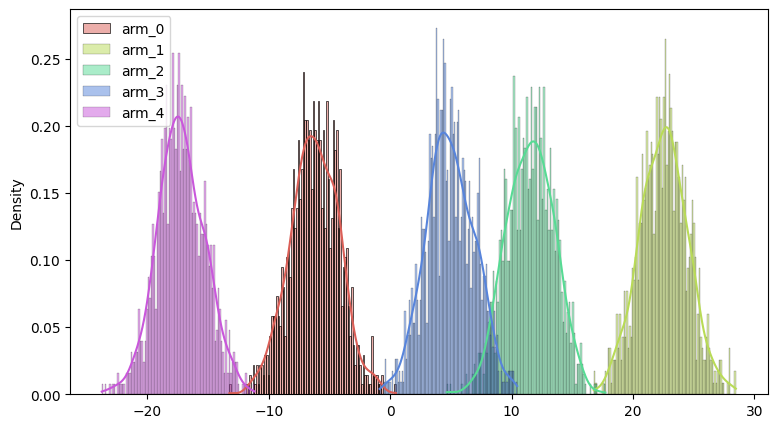

In [34]:
env = Env(num_arms, mean_reward_range, std)
env.plot_arms_reward_distribution()

In [35]:
best_arm, max_mean_reward = env.get_best_arm_and_expected_reward()
print(best_arm, max_mean_reward)

1 22.53571532049581


In [36]:
print(env.get_avg_arm_reward())

3.119254917081568


#### Please explore following values:

- Epsilon greedy: [0.001, 0.01, 0.5, 0.9]
- Softmax: [0.001, 1.0, 5.0, 50.0]

regret for random: 3871.625


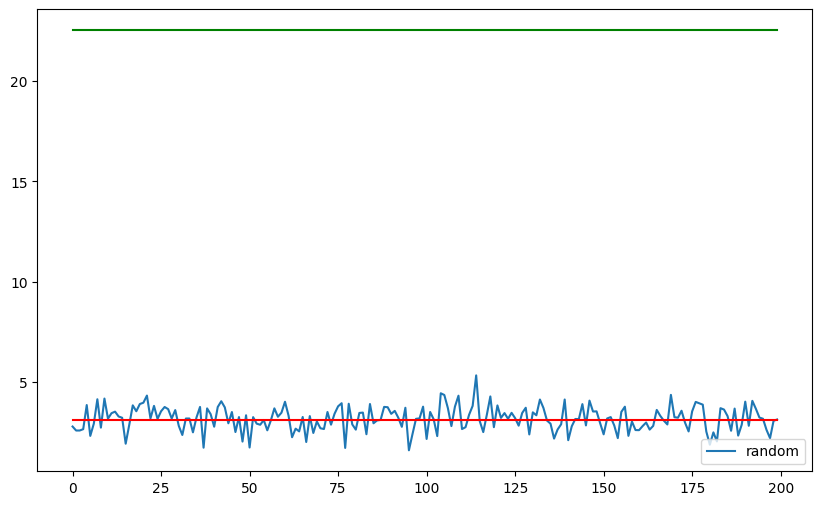

[3871.6249859602067]

In [37]:
random_policy = RandomPolicy(env.arm_ids)
plot_reward_curve_and_print_regret(env, [random_policy], timesteps=200, num_runs=500)

regret for ep-greedy ep:0.001: 39.590
regret for ep-greedy ep:0.01: 83.511
regret for ep-greedy ep:0.5: 1980.353
regret for ep-greedy ep:0.9: 3505.350


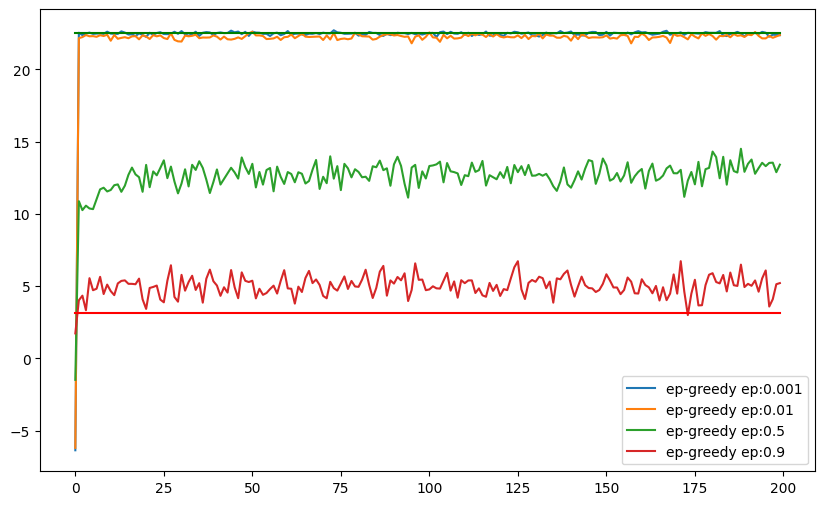

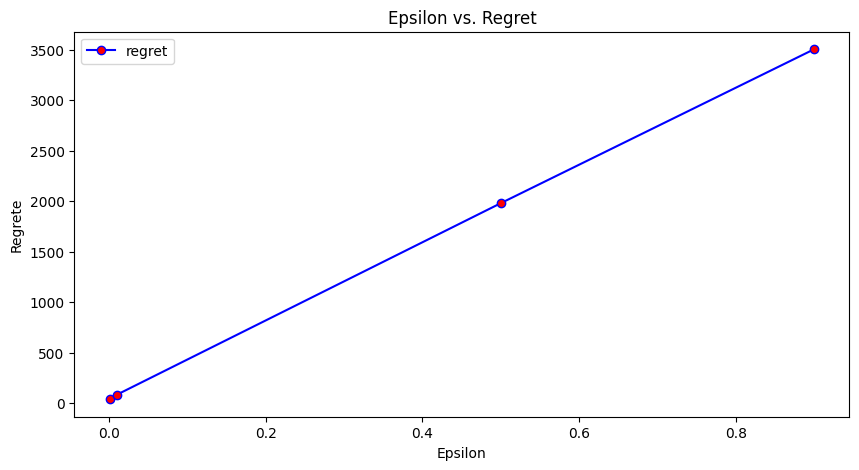

In [38]:
explore_epgreedy_epsilons =  [0.001, 0.01, 0.5, 0.9]
epgreedy_policies = [EpGreedyPolicy(ep, env.arm_ids) for ep in explore_epgreedy_epsilons]
regretes = plot_reward_curve_and_print_regret(env, epgreedy_policies, timesteps=200, num_runs=500)
print("\n")
plot_constants_vs_regretes(explore_epgreedy_epsilons, regretes, "Epsilon")

regret for softmax tau:0.001: 1922.557
regret for softmax tau:1.0: 1344.711
regret for softmax tau:5.0: 411.401
regret for softmax tau:50.0: 3150.510


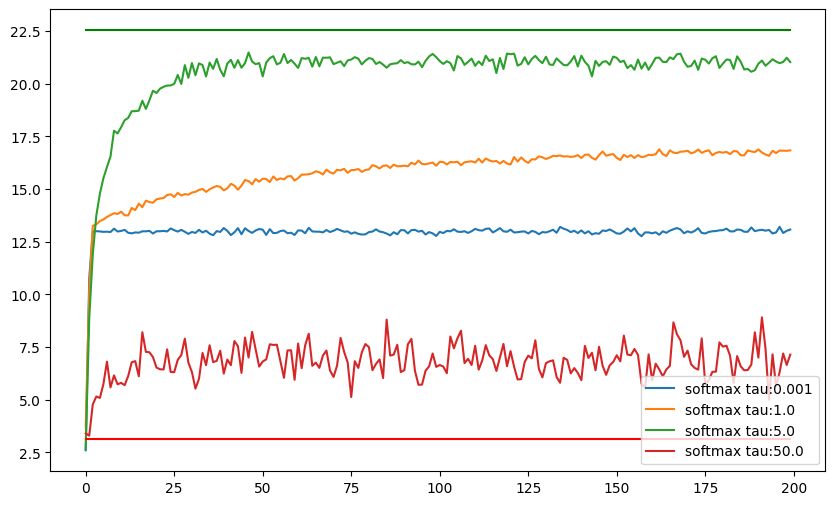

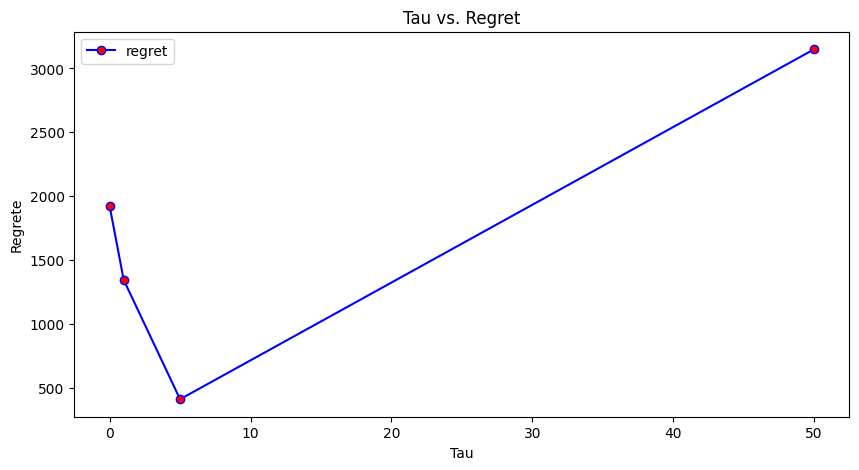

In [39]:
explore_softmax_taus =  [0.001, 1.0, 5.0, 50.0]
softmax_polices = [SoftmaxPolicy(tau, env.arm_ids) for tau in explore_softmax_taus]
regretes = plot_reward_curve_and_print_regret(env, softmax_polices, timesteps=200, num_runs=500)
print("\n")
plot_constants_vs_regretes(explore_softmax_taus, regretes, "Tau")

regret for ucb c:4: 27.132


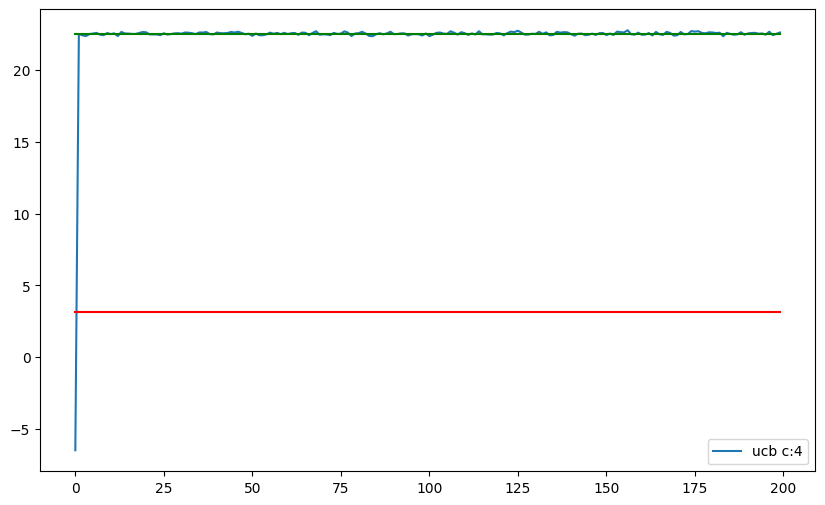

[27.13243660984699]

In [40]:
plot_reward_curve_and_print_regret(env, [UCB(4, env.arm_ids)], timesteps=200, num_runs=500)

regret for ucb c:0.5: 29.291
regret for ucb c:10: 29.291
regret for ucb c:20: 361.793
regret for ucb c:30: 622.310


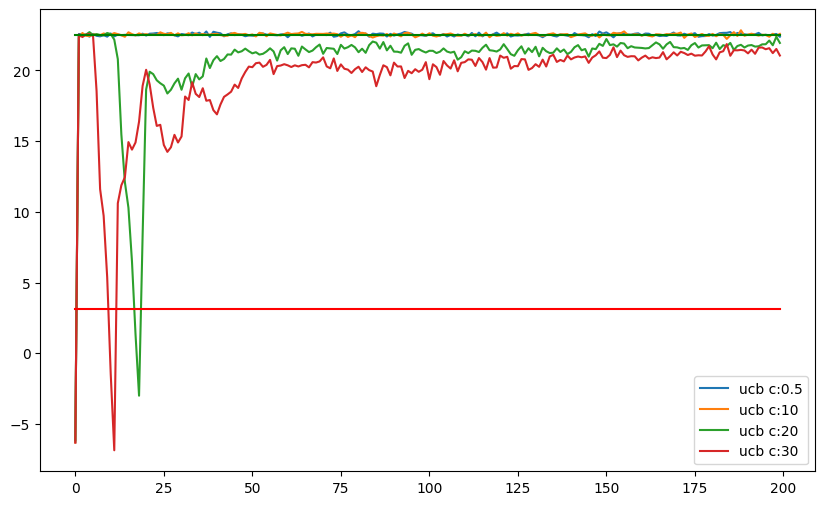

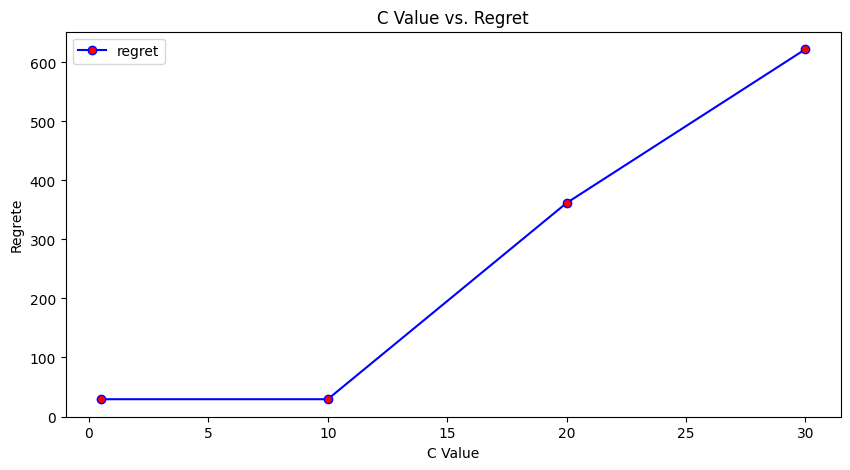

In [41]:
# c_value settings for UCB Policy
ucb_c_values = [0.5, 10, 20, 30]
ucb_policies = [UCB(c_value, env.arm_ids) for c_value in ucb_c_values]
regretes = plot_reward_curve_and_print_regret(env, ucb_policies, timesteps=200, num_runs=500)
print("\n")
plot_constants_vs_regretes(ucb_c_values, regretes, 'C Value')

#### Optional: Please explore different values of epsilon, tau and verify how does the behaviour changes.

regret for ep-greedy ep:0.03: 198.610
regret for ep-greedy ep:0.24: 1005.173
regret for ep-greedy ep:0.67: 2626.136
regret for ep-greedy ep:0.99: 3848.057


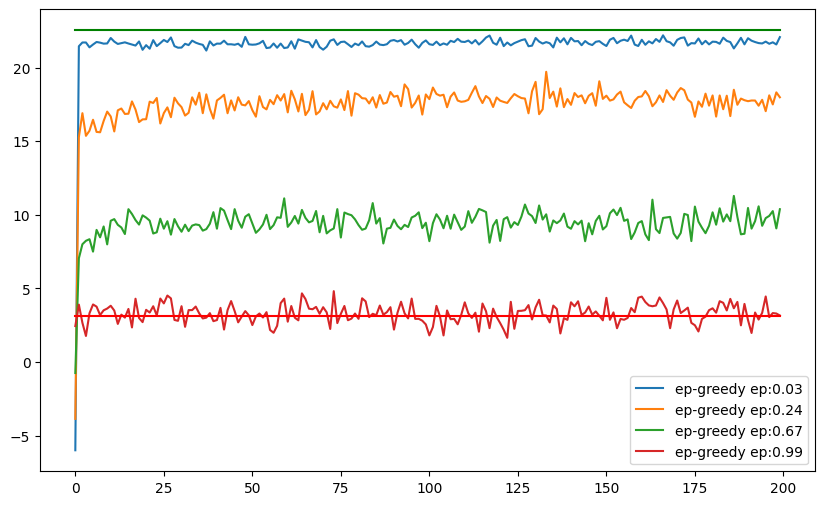

regret for softmax tau:0.07: 1903.306
regret for softmax tau:3.0: 329.768
regret for softmax tau:14.0: 1723.451
regret for softmax tau:100.0: 3510.837


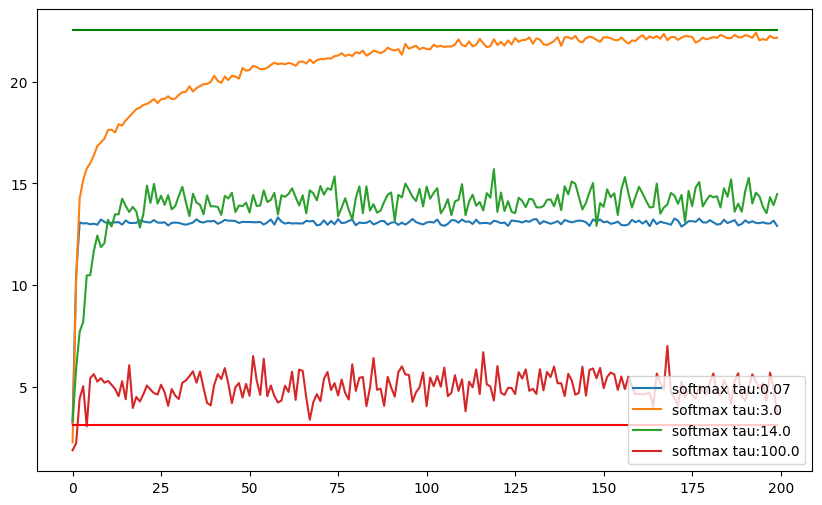

[1903.3055186135366, 329.7684470639515, 1723.4509903683597, 3510.8366958489337]

In [42]:
# Assuming the environment setup and policies are already defined as per your previous code.

# Epsilon values for Epsilon-Greedy Policy
explore_epgreedy_epsilons = [0.03, 0.24, 0.67, 0.99]

# Tau values for Softmax Policy
explore_softmax_taus = [0.07, 3.0, 14.0, 100.0]

# Creating policy instances
epgreedy_policies = [EpGreedyPolicy(ep, env.arm_ids) for ep in explore_epgreedy_epsilons]
softmax_policies = [SoftmaxPolicy(tau, env.arm_ids) for tau in explore_softmax_taus]

# Running the experiment
plot_reward_curve_and_print_regret(env, epgreedy_policies, timesteps=200, num_runs=500)
plot_reward_curve_and_print_regret(env, softmax_policies, timesteps=200, num_runs=500)